In [1]:
import pandas as pd
from pprint import pprint
from pathlib import Path
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import mplhep as hep
import datetime
hep.style.use('CMS')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, sys

import sys, os
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, '../TestBeam')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)
print(path2add)

from beamtest_analysis_helper import plot_BL_and_NW

/home/daq/ETROC2/ETROC-Analysis/TestBeam


In [3]:
left_cut = datetime.datetime(2025, 5, 1, 9, 00)
# left_cut = None
right_cut = None

## Temperature Humidity, VTemp, VRef

In [ ]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/NW_SEU_May2025/ti1080_sensor_data.sqlite')
ti_hdc1080_df = pd.read_sql_query("SELECT * from ti_hdc1080", con)
ti_hdc1080_df['timestamp'] = pd.to_datetime(ti_hdc1080_df['timestamp'])

date_form = mdates.DateFormatter("%m-%d\n%H:%M")
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20, 10))

hep.cms.text(loc=0, ax=ax[0], text="ETL ETROC NW p+ SEU Testing", fontsize=21)
ax[0].plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['temperature'],"o-")
ax[0].xaxis.set_major_formatter(date_form)
ax[0].set_ylabel('Ambient Temperature[C]', fontsize=25)
ax[0].set_xlim(left=left_cut, right=right_cut)
ax[0].set_ylim(25, 29)
ax[0].grid(which="both")

hep.cms.text(loc=0, ax=ax[1], text="ETL ETROC NW p+ SEU Testing", fontsize=21)
ax[1].plot(ti_hdc1080_df['timestamp'], ti_hdc1080_df['humidity'], "o-")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].set_ylabel('Humidity [%]')
ax[1].set_xlim(left=left_cut, right=right_cut)
# ax[1].set_ylim(-25,25)
ax[1].grid(which="both")

plt.tight_layout()

In [ ]:
con = sqlite3.connect('./ADCHistory.sqlite')
adc_df = pd.read_sql_query("SELECT * from adc", con)
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = adc_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'])

date_form = mdates.DateFormatter("%m-%d\n%H:%M")
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

hep.cms.text(loc=0, ax=ax[0], text=f"ETL ETROC NW p+ SEU Testing", fontsize=21)
ax[0].xaxis.set_major_formatter(date_form)
tmp_df = adc_df.loc[adc_df['channel']==1]
ax[0].plot(tmp_df['timestamp'], tmp_df['voltage'])
# ax[0].legend(loc='best')
ax[0].set_ylabel('VRef [V]')
ax[0].set_ylim(0.93, .96)
ax[0].set_xlim(left=left_cut)
ax[0].grid(which='both')

hep.cms.text(loc=0, ax=ax[1], text=f"ETL ETROC NW p+ SEU Testing", fontsize=21)
ax[1].xaxis.set_major_formatter(date_form)
tmp_df = adc_df.loc[adc_df['channel']==0]
ax[1].plot(tmp_df['timestamp'], (397.931*tmp_df['voltage'])-205.995)
# ax[1].legend(loc='best')
ax[1].set_ylabel('VTemp [C]')
ax[1].set_ylim(22, 29)
ax[1].set_xlim(left=left_cut)
ax[1].grid(which='both')

plt.tight_layout()

## Baseline plots

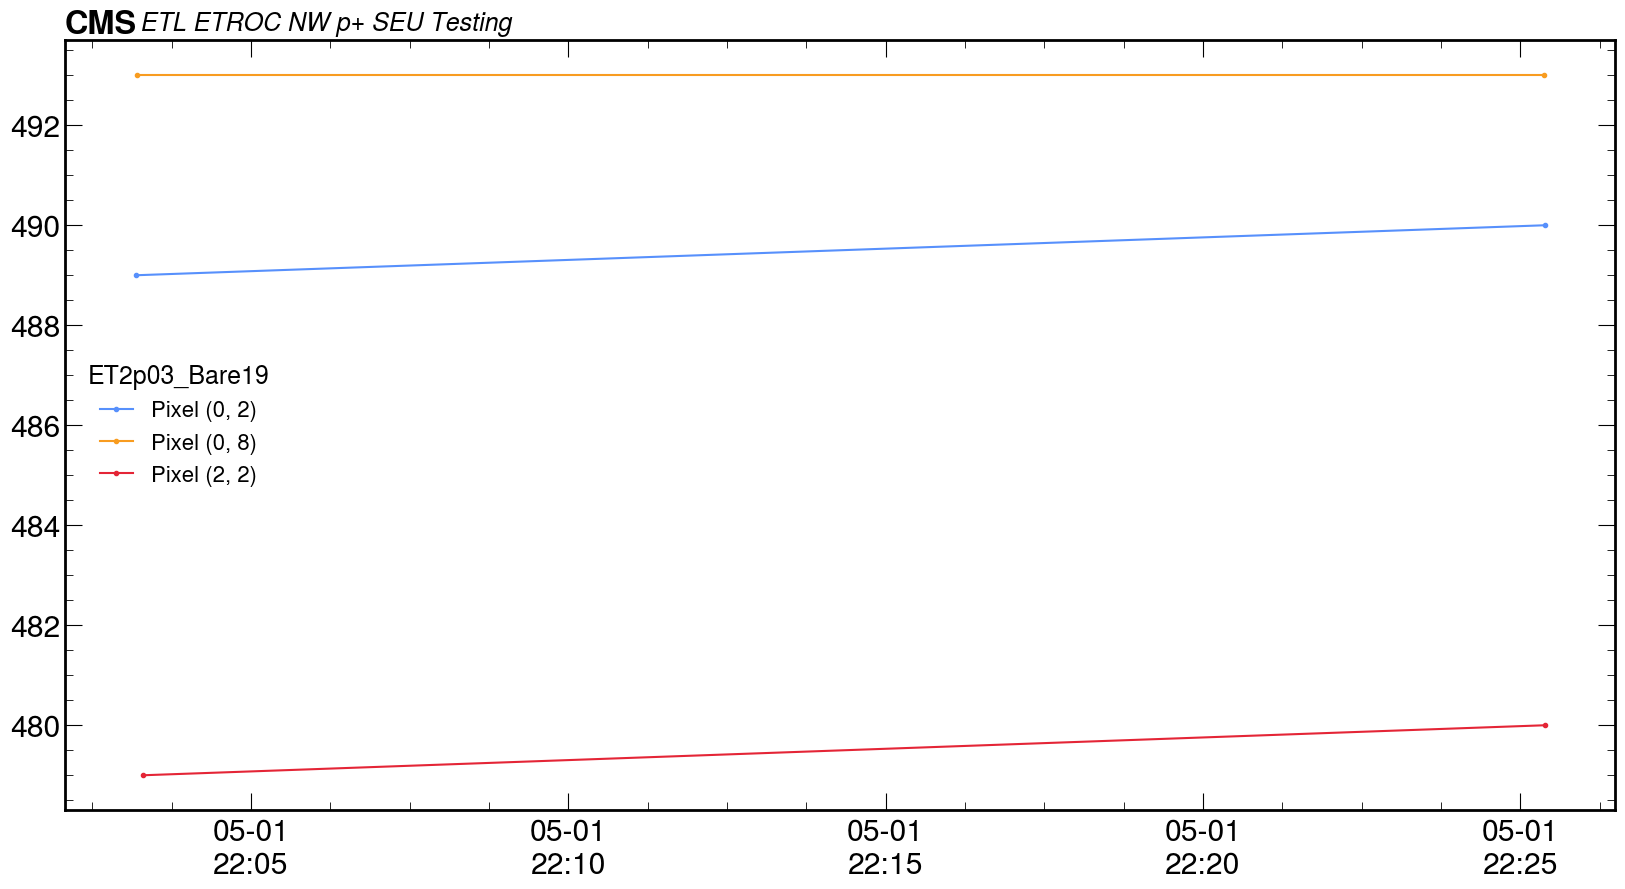

In [5]:
### Add board names in the dictionary
config_dict = {
    'ET2p03_Bare19': {
        'plot_title': 'Bare Board 19',
        'chip_type': 'T',
        'channel': 0,
    },
}
pixel_list = [(0,2),(0,8),(2,2)]

con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/NW_SEU_May2025/BaselineHistory.sqlite')

baseline_df = pd.read_sql_query("SELECT * from baselines", con)

baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
baseline_df['timestamp'] = baseline_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'])

for iboard in baseline_df['chip_name'].unique():
    if iboard not in config_dict: continue
    interest_df = baseline_df.loc[baseline_df['chip_name']==iboard]

    # print(interest_df)

    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC NW p+ SEU Testing", fontsize=18)
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    cut_time = pd.to_datetime('2025-05-1 00:00:00')

    for pixel in pixel_list:
        tmp_df = interest_df.loc[(interest_df['row'] == pixel[0]) & (interest_df['col'] == pixel[1])]
        tmp_df = tmp_df.loc[tmp_df['timestamp'] > left_cut]
        ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'Pixel ({pixel[0]}, {pixel[1]})', marker='.')

    # text_y = [200, 370]

    ax.legend(loc='center left', fontsize=16, title=f'{iboard}', title_fontsize=18)

# Power Monitoring

In [ ]:
power_file = Path("/home/daq/ETROC2/ETROC-History/NW_SEU_May2025/PowerHistory_v2.sqlite")
with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pd.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    i2c_df  = pd.read_sql('SELECT * FROM actions_v2', sqlite3_connection, index_col=None)

data_df['Time'] = pd.to_datetime(data_df['timestamp'])
i2c_df['Time']  = pd.to_datetime(i2c_df['timestamp'])

# Remove data that is outside the range of the campaign
data_df = data_df.loc[data_df['Time'] >= left_cut]
i2c_df = i2c_df.loc[i2c_df['Time'] >= left_cut]

# start_time, end_time = None, None
# data_df = data_df.loc[data_df['Time'] >= start_time]
# data_df = data_df.loc[data_df['Time'] <= end_time]
# i2c_df = i2c_df.loc[i2c_df['Time'] >= start_time]
# i2c_df = i2c_df.loc[i2c_df['Time'] <= end_time]

data_df['V'] = (data_df['V'].str.replace('V','')).astype(float)
data_df['I'] = (data_df['I'].str.replace('A','')).astype(float)

for iinst in data_df['Instrument'].unique():
    for ich in data_df['Channel'].unique():
        sub_df = data_df.loc[(data_df['Instrument'] == iinst) & (data_df['Channel'] == ich)]
        fig, axes = plt.subplots(2, 1, figsize=(20, 10))
        date_form = mdates.DateFormatter("%m-%d\n%H:%M")
        hep.cms.text(loc=0, ax=axes[0], text=f"ETL ETROC UCL HI SEU Testing: {iinst} {ich}", fontsize=21)
        axes[0].xaxis.set_major_formatter(date_form)
        axes[0].plot(sub_df['Time'], sub_df['V'])
        axes[0].set_ylabel('Voltage [V]')
        axes[1].xaxis.set_major_formatter(date_form)
        axes[1].plot(sub_df['Time'], sub_df['I'])
        axes[1].set_ylabel('Currents [A]')
        for x,m in zip(i2c_df["Time"],i2c_df["message"]):
            if(m!="Start SEU Beam" and m!="Load I2C Config" and m!="Baseline" and m!="Stop SEU Beam"): continue
            axes[0].axvline(x, c='k', ls='--')
            trans = axes[0].get_xaxis_transform()
            axes[0].text(x, 0.5, m, ha='center',va='center', transform=trans, rotation="vertical", size=10)
            axes[1].axvline(x, c='k', ls='--')
            trans = axes[1].get_xaxis_transform()
            axes[1].text(x, 0.5, m, ha='center',va='center', transform=trans, rotation="vertical", size=10)
        plt.tight_layout()

# Invalid FC Counters

In [4]:
power_file = Path("/home/daq/ETROC2/ETROC-History/NW_SEU_May2025/PowerHistory_v2.sqlite")
with sqlite3.connect(power_file) as sqlite3_connection:
    i2c_df  = pd.read_sql('SELECT * FROM actions_v2', sqlite3_connection, index_col=None)

power_file = Path("/home/daq/ETROC2/ETROC-History/NW_SEU_May2025/InvalidFCCounterHistory.sqlite")
with sqlite3.connect(power_file) as sqlite3_connection:
    data_df  = pd.read_sql('SELECT * FROM baselines', sqlite3_connection, index_col=None)

data_df['Time'] = pd.to_datetime(data_df['timestamp'])
i2c_df['Time']  = pd.to_datetime(i2c_df['timestamp'])

# Remove data that is outside the range of the campaign
data_df = data_df.loc[data_df['Time'] >= left_cut]
i2c_df = i2c_df.loc[i2c_df['Time'] >= left_cut]

# start_time, end_time = None, None
# data_df = data_df.loc[data_df['Time'] >= start_time]
# data_df = data_df.loc[data_df['Time'] <= end_time]
# i2c_df = i2c_df.loc[i2c_df['Time'] >= start_time]
# i2c_df = i2c_df.loc[i2c_df['Time'] <= end_time]

for iinst in data_df['chip_name'].unique():
    sub_df = data_df.loc[(data_df['chip_name'] == iinst)]
    fig, axes = plt.subplots(1, 1, figsize=(20, 10))
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    hep.cms.text(loc=0, ax=axes, text=f"ETL ETROC UCL HI SEU Testing", fontsize=21)
    axes.xaxis.set_major_formatter(date_form)
    axes.plot(sub_df['Time'], sub_df['invalid_fc_counter'])
    axes.set_ylabel('Invalid FC Counter')
    for x,m in zip(i2c_df["Time"],i2c_df["message"]):
        if(m!="Start SEU Beam" and m!="Load I2C Config" and m!="Stop SEU Beam"): continue
        axes.axvline(x, c='k', ls='--')
        trans = axes.get_xaxis_transform()
        axes.text(x, 0.5, m, ha='center',va='center', transform=trans, rotation="vertical", size=10)
    plt.tight_layout()

DatabaseError: Execution failed on sql 'SELECT * FROM baselines': no such table: baselines